<b><font color="SteelBlue" size="+3">Implémentez un modèle de scoring</font></b>

# Introduction

Ce note book est la suite de l'EDA, il va permettre de présenter le prétraitement des données, le feature engineering et la modélisation.

In [3]:
# Chargement des librairies

# Built-in
import os
import re
import time
# Affichage
from IPython.display import Image

# Manipulation et analyse des données
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Machine Learning - Suivi et Enregistrement
import mlflow
import mlflow.sklearn

# Machine Learning - Prétraitement
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold, RandomizedSearchCV
from sklearn.utils.class_weight import compute_class_weight

# Machine Learning - Algorithmes
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from xgboost import XGBClassifier
import lightgbm as lgb
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier, Pool

# Machine Learning - Équilibrage des données
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# Machine Learning - Sélection de caractéristiques
from sklearn.feature_selection import RFECV

# Machine Learning - Évaluation des performances
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score, make_scorer
from sklearn.metrics import f1_score

# Features importance
import shap

# Transformateur
from sklearn.base import BaseEstimator, ClassifierMixin, TransformerMixin

# Data drift
from evidently.report import Report
from evidently.metric_preset import DataDriftPreset

# Pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
import joblib

# Custom Feature Engineering Pipeline
from feature_pipeline import FeatureEngineeringPipeline, remove_highly_correlated_features

In [2]:
mlflow.set_tracking_uri(uri="http://127.0.0.1:5000")
mlflow.set_experiment("Credit_Scoring_Experiment")

<Experiment: artifact_location='mlflow-artifacts:/185199612184583695', creation_time=1715766694823, experiment_id='185199612184583695', last_update_time=1715766694823, lifecycle_stage='active', name='Credit_Scoring_Experiment', tags={}>

# Data préparation

## Chargement des données

In [4]:
os.listdir("data/sources/")

['application_test.csv',
 'application_train.csv',
 'bureau.csv',
 'bureau_balance.csv',
 'credit_card_balance.csv',
 'HomeCredit_columns_description.csv',
 'installments_payments.csv',
 'POS_CASH_balance.csv',
 'previous_application.csv',
 'Projet+Mise+en+prod+-+home-credit-default-risk.zip',
 'sample_submission.csv']

In [5]:
PATH = "./data/sources/"

In [6]:
application_train = pd.read_csv(PATH+"/application_train.csv")
application_test = pd.read_csv(PATH+"/application_test.csv")
bureau = pd.read_csv(PATH+"/bureau.csv")
bureau_balance = pd.read_csv(PATH+"/bureau_balance.csv")
credit_card_balance = pd.read_csv(PATH+"/credit_card_balance.csv")
installments_payments = pd.read_csv(PATH+"/installments_payments.csv")
previous_application = pd.read_csv(PATH+"/previous_application.csv")
POS_CASH_balance = pd.read_csv(PATH+"/POS_CASH_balance.csv")

In [7]:
application_train.shape

(307511, 122)

## Split du jeu de données

In [147]:
# Division des données en ensembles d'entraînement et de test
train, test = train_test_split(application_train, test_size=0.2, random_state=21, stratify=application_train['TARGET'])

## Gestion des valeurs manquantes et infinies

In [149]:
# Supprimer les lignes où TARGET est manquant dans application_train
train.dropna(subset=['TARGET'], inplace=True)
test.dropna(subset=['TARGET'], inplace=True)

In [10]:
# Suppression des lignes où les clés sont absentes
def drop_missing_keys(df, key, reference_df, reference_key):
    valid_keys = reference_df[reference_key].unique()
    return df[df[key].isin(valid_keys)]

# Supprimer les lignes où les clés sont absentes
bureau = drop_missing_keys(bureau, 'SK_ID_CURR', application_train, 'SK_ID_CURR')
bureau_balance = drop_missing_keys(bureau_balance, 'SK_ID_BUREAU', bureau, 'SK_ID_BUREAU')
previous_application = drop_missing_keys(previous_application, 'SK_ID_CURR', application_train, 'SK_ID_CURR')
POS_CASH_balance = drop_missing_keys(POS_CASH_balance, 'SK_ID_PREV', previous_application, 'SK_ID_PREV')
installments_payments = drop_missing_keys(installments_payments, 'SK_ID_PREV', previous_application, 'SK_ID_PREV')
credit_card_balance = drop_missing_keys(credit_card_balance, 'SK_ID_PREV', previous_application, 'SK_ID_PREV')

In [8]:
# Remplacement des valeurs infinie par nan
def replace_infinite_values(df):
    return df.replace([np.inf, -np.inf], np.nan)

In [17]:
# Appliquer le filtre des colonnes manquantes et la gestion des valeurs infinies à chaque DataFrame
dfs = {
    "Train": train,
    "Test": test,
    "Application Test": application_test,
    "Bureau": bureau,
    "Bureau Balance": bureau_balance,
    "Credit Card Balance": credit_card_balance,
    "Installments Payments": installments_payments,
    "Previous Application": previous_application,
    "POS CASH Balance": POS_CASH_balance
}

In [18]:
for name, df in dfs.items():
    df = replace_infinite_values(df)
    dfs[name] = df

In [19]:
dfs['Train'].shape

(246008, 122)

## Imputation

In [20]:
dfs_imputed = dfs

In [21]:
# Fonction pour imputer les valeurs manquantes
def impute_missing_values(df):
    # Imputation pour les colonnes numériques
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    for col in numeric_cols:
        df[col].fillna(df[col].median(), inplace=True)
    
    # Imputation pour les colonnes catégorielles
    categorical_cols = df.select_dtypes(include=[object]).columns
    for col in categorical_cols:
        df[col].fillna(df[col].mode()[0], inplace=True)
    
    return df

In [22]:
for name, df in dfs_imputed.items():
    df = impute_missing_values(df)
    dfs_imputed[name] = df

In [23]:
# Fonction pour vérifier les valeurs manquantes dans un DataFrame
def check_missing_values(df):
    missing_values = df.isnull().sum()
    missing_values = missing_values[missing_values > 0]
    if not missing_values.empty:
        print("Colonnes avec des valeurs manquantes :")
        print(missing_values)
    else:
        print("Aucune valeur manquante détectée.")


In [24]:
# Vérification des valeurs manquantes dans chaque DataFrame
for name, df in dfs_imputed.items():
    print(f"\n{name}:")
    check_missing_values(df)


Train:
Aucune valeur manquante détectée.

Test:
Aucune valeur manquante détectée.

Application Test:
Aucune valeur manquante détectée.

Bureau:
Aucune valeur manquante détectée.

Bureau Balance:
Aucune valeur manquante détectée.

Credit Card Balance:
Aucune valeur manquante détectée.

Installments Payments:
Aucune valeur manquante détectée.

Previous Application:
Aucune valeur manquante détectée.

POS CASH Balance:
Aucune valeur manquante détectée.


In [25]:
dfs_imputed['Train'].shape

(246008, 122)

## Sauvegarde des données nettoyées

In [9]:
# Fonction pour sauvegarder un DataFrame
def save_dataframe(df, filename, output_dir):
    output_path = os.path.join(output_dir, filename)
    df.to_csv(output_path, index=False)
    print(f"DataFrame sauvegardé sous : {output_path}")

In [27]:
# Dictionnaire contenant les noms des fichiers
original_names = {
    "Train": "train.csv",
    "Test": "test.csv",
    "Application Test": "application_test.csv",
    "Bureau": "bureau.csv",
    "Bureau Balance": "bureau_balance.csv",
    "Credit Card Balance": "credit_card_balance.csv",
    "Installments Payments": "installments_payments.csv",
    "Previous Application": "previous_application.csv",
    "POS CASH Balance": "POS_CASH_balance.csv"
}

### Sans l'imputation

In [28]:
# Chemin du dossier où sauvegarder les DataFrames nettoyés
output_dir = "data/Cleaned"

In [29]:
# Sauvegarder chaque DataFrame dans le dossier output_dir avec le nom d'origine
for name, df in dfs.items():
    save_dataframe(df, original_names[name], output_dir)

DataFrame sauvegardé sous : data/Cleaned\train.csv
DataFrame sauvegardé sous : data/Cleaned\test.csv
DataFrame sauvegardé sous : data/Cleaned\application_test.csv
DataFrame sauvegardé sous : data/Cleaned\bureau.csv
DataFrame sauvegardé sous : data/Cleaned\bureau_balance.csv
DataFrame sauvegardé sous : data/Cleaned\credit_card_balance.csv
DataFrame sauvegardé sous : data/Cleaned\installments_payments.csv
DataFrame sauvegardé sous : data/Cleaned\previous_application.csv
DataFrame sauvegardé sous : data/Cleaned\POS_CASH_balance.csv


### Avec l'imputation

In [30]:
# Chemin du dossier où sauvegarder les DataFrames nettoyés
output_dir_imputed = "data/Cleaned/Imputed"

In [31]:
# Sauvegarder chaque DataFrame dans le dossier output_dir avec le nom d'origine
for name, df in dfs_imputed.items():
    save_dataframe(df, original_names[name], output_dir_imputed)

DataFrame sauvegardé sous : data/Cleaned/Imputed\train.csv
DataFrame sauvegardé sous : data/Cleaned/Imputed\test.csv
DataFrame sauvegardé sous : data/Cleaned/Imputed\application_test.csv
DataFrame sauvegardé sous : data/Cleaned/Imputed\bureau.csv
DataFrame sauvegardé sous : data/Cleaned/Imputed\bureau_balance.csv
DataFrame sauvegardé sous : data/Cleaned/Imputed\credit_card_balance.csv
DataFrame sauvegardé sous : data/Cleaned/Imputed\installments_payments.csv
DataFrame sauvegardé sous : data/Cleaned/Imputed\previous_application.csv
DataFrame sauvegardé sous : data/Cleaned/Imputed\POS_CASH_balance.csv


# Feature engineering

## Sur jeu non imputé

### Sur le df train

In [32]:
# Initialiser le pipeline
pipeline = FeatureEngineeringPipeline(data_directory=output_dir + '/')

In [33]:
# Entraîner le pipeline
train_transformed = pipeline.fit(dfs['Train'])

feature_engineering - done
Bureau and bureau_balance data - done in 38s
previous_application - done in 41s
previous applications balances - done in 515s
Gestion des valeurs infinies
Colonnes supprimées (constantes): 0, Colonnes restantes: 733
Initial df memory usage is 1382.54 MB for 851 columns
Final memory usage is: 505.34 MB - decreased by 63.4%


In [34]:
# Sauvegarder les paramètres de transformation
pipeline.save(os.path.join(output_dir, "param"))

In [35]:
train_transformed.shape

(246003, 851)

In [36]:
train_transformed.head(5)

,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,HOUSETYPE_MODE_block of flats,HOUSETYPE_MODE_specific housing,HOUSETYPE_MODE_terraced house,WALLSMATERIAL_MODE_Block,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
183096,1,0,0,0,1,0,135000.0,161730.0,8464.5,135000.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
433941,0,0,0,1,0,0,225000.0,729792.0,22126.5,630000.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
378379,0,0,1,0,1,0,121500.0,911263.5,36270.0,814500.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
301108,0,0,0,0,1,0,180000.0,808650.0,23773.5,675000.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
194730,0,0,1,1,1,0,180000.0,355536.0,15192.0,270000.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [37]:
check_missing_values(train_transformed)

Colonnes avec des valeurs manquantes :
DAYS_EMPLOYED                       44589
DAYS_LAST_PHONE_CHANGE              30094
INCOME_TO_EMPLOYED_RATIO            44591
EMPLOYED_TO_BIRTH_RATIO             44589
CAR_TO_EMPLOYED_RATIO               44591
                                    ...  
CTA_CREDIT_TO_ANNUITY_MEAN_RATIO    13990
DAYS_DECISION_MEAN_TO_BIRTH         13977
DAYS_CREDIT_MEAN_TO_BIRTH           35323
DAYS_DECISION_MEAN_TO_EMPLOYED      56182
DAYS_CREDIT_MEAN_TO_EMPLOYED        73145
Length: 587, dtype: int64


### Sur le df test

In [38]:
# Charger les paramètres de transformation
pipeline.load(os.path.join(output_dir, "param"))

# Transformer les données de test
test_transformed = pipeline.transform(dfs['Test'])

Bureau and bureau_balance data - done in 36s
previous_application - done in 38s
Gestion des valeurs infinies
Initial df memory usage is 398.61 MB for 851 columns
Final memory usage is: 118.54 MB - decreased by 70.3%
previous applications balances - done in 502s


In [39]:
test_transformed.shape

(61503, 851)

## Sur jeu imputé

### Sur le df train

In [40]:
# Initialiser le pipeline
pipeline_imp = FeatureEngineeringPipeline(data_directory=output_dir_imputed + '/')

In [41]:
# Entraîner le pipeline
train_imputed_transformed = pipeline_imp.fit(dfs_imputed['Train'])

feature_engineering - done
Bureau and bureau_balance data - done in 36s
previous_application - done in 39s
previous applications balances - done in 495s
Gestion des valeurs infinies
Gestion des valeurs manquantes - done
Colonnes supprimées (constantes): 0, Colonnes restantes: 733
Initial df memory usage is 1382.54 MB for 851 columns
Final memory usage is: 505.34 MB - decreased by 63.4%


In [42]:
# Sauvegarder les paramètres de transformation
pipeline_imp.save(os.path.join(output_dir_imputed, "param"))

In [43]:
train_imputed_transformed.shape

(246003, 851)

In [44]:
train_imputed_transformed.head(5)

,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,HOUSETYPE_MODE_block of flats,HOUSETYPE_MODE_specific housing,HOUSETYPE_MODE_terraced house,WALLSMATERIAL_MODE_Block,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
183096,1,0,0,0,1,0,135000.0,161730.0,8464.5,135000.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
433941,0,0,0,1,0,0,225000.0,729792.0,22126.5,630000.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
378379,0,0,1,0,1,0,121500.0,911263.5,36270.0,814500.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
301108,0,0,0,0,1,0,180000.0,808650.0,23773.5,675000.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
194730,0,0,1,1,1,0,180000.0,355536.0,15192.0,270000.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [45]:
check_missing_values(train_imputed_transformed)

Aucune valeur manquante détectée.


### Sur le df test

In [46]:
# Charger les paramètres de transformation
pipeline_imp.load(os.path.join(output_dir_imputed, "param"))

# Transformer les données de test
test_imputed_transformed = pipeline_imp.transform(dfs_imputed['Test'])

Bureau and bureau_balance data - done in 36s
previous_application - done in 39s
Gestion des valeurs infinies
Gestion des valeurs manquantes - done
Initial df memory usage is 398.61 MB for 851 columns
Final memory usage is: 118.54 MB - decreased by 70.3%
previous applications balances - done in 498s


In [47]:
test_imputed_transformed.shape

(61503, 851)

In [48]:
# Vérification des colonnes avec des valeurs manquantes
missing_values = test_imputed_transformed.isnull().sum()
missing_columns = missing_values[missing_values > 0].index.tolist()
print(f"Colonnes avec des valeurs manquantes : {missing_columns}")

Colonnes avec des valeurs manquantes : []


## Sauvegarde / Chargement des données

In [49]:
output_feat_dir = "data/Featured"

# Enregistrer les DataFrames dans des fichiers CSV
train_transformed.to_csv(os.path.join(output_feat_dir, "train_transformed.csv"), index=False)
test_transformed.to_csv(os.path.join(output_feat_dir, "test_transformed.csv"), index=False)
train_imputed_transformed.to_csv(os.path.join(output_feat_dir, "train_imputed_transformed.csv"), index=False)
test_imputed_transformed.to_csv(os.path.join(output_feat_dir, "test_imputed_transformed.csv"), index=False)

print("DataFrames enregistrés avec succès.")

DataFrames enregistrés avec succès.


In [10]:
# Vérification de l'existence de la variable output_feat_dir
try:
    output_feat_dir
except NameError:
    output_feat_dir = None

if output_feat_dir is None:
    output_feat_dir = "data/Featured"

    # Charger les DataFrames à partir des fichiers CSV
    train_transformed = pd.read_csv(os.path.join(output_feat_dir, "train_transformed.csv"))
    test_transformed = pd.read_csv(os.path.join(output_feat_dir, "test_transformed.csv"))
    train_imputed_transformed = pd.read_csv(os.path.join(output_feat_dir, "train_imputed_transformed.csv"))
    test_imputed_transformed = pd.read_csv(os.path.join(output_feat_dir, "test_imputed_transformed.csv"))

    print("DataFrames chargés avec succès.")

DataFrames chargés avec succès.


In [11]:
print(f"train_transformed : {train_transformed.shape},\n"
      f"test_transformed : {test_transformed.shape},\n"
      f"train_imputed_transformed : {train_imputed_transformed.shape},\n"
      f"test_imputed_transformed : {test_imputed_transformed.shape}")

train_transformed : (246003, 851),
test_transformed : (61503, 851),
train_imputed_transformed : (246003, 851),
test_imputed_transformed : (61503, 851)


In [12]:
# nettoyage des noms de colonnes
def clean_column_names(df):
    df.columns = [re.sub(r'[^A-Za-z0-9_]+', '', col) for col in df.columns]
    return df

train_transformed = clean_column_names(train_transformed)
test_transformed = clean_column_names(test_transformed)
train_imputed_transformed = clean_column_names(train_imputed_transformed)
test_imputed_transformed = clean_column_names(test_imputed_transformed)

# Définition du Score Métier

In [13]:
def normalized_cost_function(y_true, y_pred):
    fp_cost = 1
    fn_cost = 10
    fp = np.sum((y_true == 0) & (y_pred == 1))
    fn = np.sum((y_true == 1) & (y_pred == 0))
    cost = (fp_cost * fp + fn_cost * fn) / len(y_true)
    return cost

In [14]:
# Création du custom score avec la fonction cost
custom_scorer = make_scorer(normalized_cost_function, greater_is_better=False)

# Modèles de machine learning

## Préparation

In [15]:
# Séparer les features et la cible sur le jeu sans imputation
X_train = train_transformed.drop(columns=['TARGET'])
y_train = train_transformed['TARGET']
X_test = test_transformed.drop(columns=['TARGET'])
y_test = test_transformed['TARGET']

In [16]:
# Séparer les features et la cible sur le jeu imputé
X_train_imputed = train_imputed_transformed.drop(columns=['TARGET'])
y_train_imputed = train_imputed_transformed['TARGET']
X_test_imputed = test_imputed_transformed.drop(columns=['TARGET'])
y_test_imputed = test_imputed_transformed['TARGET']

### Séléction des variables

#### Suppression des variables hautement corrélées et des variables trop peu renseignées

In [10]:
# Fonction pour supprimer les colonnes avec plus de 50% de valeurs manquantes
def drop_high_missing_columns(df, threshold=0.5):
    missing_percentage = df.isnull().mean()
    columns_to_drop = missing_percentage[missing_percentage > threshold].index
    print(f"Variables avec + de 50% de valeurs manquantes: {len(columns_to_drop)}")
    return df.drop(columns=columns_to_drop)

In [11]:
train_clean = drop_high_missing_columns(train_transformed, 0.5)
train_clean.shape

(246003, 661)

In [12]:
train_cleaned, high_corr_features = remove_highly_correlated_features(train_clean, threshold=0.9)
print(f"Variables très corrélées supprimées: {len(high_corr_features)}")

Variables très corrélées supprimées: 151


In [13]:
train_cleaned.shape

(246003, 510)

In [14]:
# Aligner les colones du jeu de test

train_cleaned_columns = list(train_cleaned.columns)
test_cleaned = test_transformed.copy()

# Supprimer les colonnes en trop
extra_cols = set(test_cleaned.columns) - set(train_cleaned_columns)
if extra_cols:
    test_cleaned.drop(columns=list(extra_cols), inplace=True)

# Réordonner les colonnes pour correspondre à celles du train
test_cleaned = test_cleaned[train_cleaned_columns]

test_cleaned.shape

(61503, 510)

In [15]:
# Séparer les features et la cible
X_train = train_cleaned.drop(columns=['TARGET'])
y_train = train_cleaned['TARGET']
X_test = test_cleaned.drop(columns=['TARGET'])
y_test = test_cleaned['TARGET']

#### Recherche de la feature importance (CatBoost + RFECV)

In [16]:
# Modèle CatBoost
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights_catboost = class_weights.tolist()
catboost_model = CatBoostClassifier(verbose=0, class_weights=class_weights_catboost, thread_count=-1, task_type="GPU", random_seed=42)

In [17]:
# Entrainer le modèle
catboost_model.fit(X_train, y_train)

# Obtenir l'importance des caractéristiques
feature_importances = catboost_model.get_feature_importance()
sorted_idx = np.argsort(feature_importances)[::-1]

# Fonction pour évaluer le modèle avec un sous-ensemble de caractéristiques
def evaluate_model_with_features(n_features, X_train, y_train, X_test, y_test):
    selected_features = sorted_idx[:n_features]
    X_train_selected = X_train.iloc[:, selected_features]
    X_test_selected = X_test.iloc[:, selected_features]
    
    catboost_model.fit(X_train_selected, y_train)
    y_pred_proba = catboost_model.predict_proba(X_test_selected)[:, 1]
    score = roc_auc_score(y_test, y_pred_proba)
    return score

In [18]:
# Créer une instance de RFECV avec CatBoostClassifier
rfecv = RFECV(
    estimator=catboost_model,
    step=1, 
    cv=StratifiedKFold(5), 
    scoring=make_scorer(roc_auc_score),
    verbose=0
)

In [19]:
# Entraîner le RFECV sur les données d'entraînement
rfecv.fit(X_train, y_train)

RFECV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
      estimator=<catboost.core.CatBoostClassifier object at 0x0000017D5EE26360>,
      scoring=make_scorer(roc_auc_score, response_method='predict'))

In [20]:
# Obtenir le nombre optimal de caractéristiques
optimal_n_features = rfecv.n_features_
print(f"Nombre optimal de caractéristiques: {optimal_n_features}")

Nombre optimal de caractéristiques: 349


In [21]:
# Obtenir la liste des caractéristiques sélectionnées
selected_features_mask = rfecv.support_
selected_features_list = X_train.columns[selected_features_mask].tolist()

# Créer un DataFrame avec les caractéristiques sélectionnées
selected_features = pd.DataFrame(selected_features_list, columns=["Selected Features"])

In [22]:
selected_features.shape

(349, 1)

#### Sauvegarde / Chargement des features

In [25]:
# Sauvegarde des features selectionnées
save_dataframe(selected_features, "features.csv", output_feat_dir)

DataFrame sauvegardé sous : data/Featured\features.csv


In [17]:
# Charger la liste des features selectionnées
# Vérification de l'existence de la variable selected_features
try:
    selected_features
except NameError:
    selected_features = None

if selected_features is None:
    # Définir la variable selected_features ici
    selected_features = pd.read_csv(os.path.join(output_feat_dir, "features.csv"))
    print("Features chargés avec succès.")

    # Séparer les features et la cible sur le jeu imputé
    X_train_imputed = train_imputed_transformed.drop(columns=['TARGET'])
    y_train_imputed = train_imputed_transformed['TARGET']
    X_test_imputed = test_imputed_transformed.drop(columns=['TARGET'])
    y_test_imputed = test_imputed_transformed['TARGET']

    selected_features_list = selected_features.iloc[:, 0].tolist()

Features chargés avec succès.


In [18]:
X_train_imputed.shape

(246003, 850)

In [19]:
# Filtrer les jeux de données pour ne garder que les features sélectionnées
X_train_imp_selected = train_imputed_transformed[selected_features_list]
X_test_imp_selected = test_imputed_transformed[selected_features_list]

# idem sur jeu non imputé
X_train_selected = X_train[selected_features_list]
X_test_selected = X_test[selected_features_list]  

In [20]:
X_train_imp_selected.shape

(246003, 349)

In [21]:
X_test_imp_selected.shape

(61503, 349)

In [22]:
X_train_selected.shape

(246003, 349)

### Standardisation

In [23]:
# Normaliser les données
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imp_selected)
X_test_scaled = scaler.transform(X_test_imp_selected)

In [24]:
X_train_scaled.shape

(246003, 349)

### Ensemble de validation

In [25]:
# Division des données d'entraînement en sous-ensembles d'entraînement et de validation sur jeu non imputé
X_train_part, X_val_part, y_train_part, y_val_part = train_test_split(X_train_selected, y_train,
                                                                      test_size=0.2, random_state=42,
                                                                      stratify=y_train)

In [26]:
# Division des données d'entraînement en sous-ensembles d'entraînement et de validation sur jeu imputé
X_train_imp_part, X_val_imp_part, y_train_imp_part, y_val_imp_part = train_test_split(X_train_imp_selected, y_train_imputed,
                                                                                      test_size=0.2, random_state=42,
                                                                                      stratify=y_train_imputed)

## Tests de différents modèles

In [27]:
# Liste des modèles à tester
dummy_model = DummyClassifier(strategy='most_frequent')
logistic_model = LogisticRegression(random_state=42, max_iter=2000, n_jobs=-1)

# Calcul de scale_pos_weight pour XGBoost
scale_pos_weight = sum(y_train == 0) / sum(y_train == 1)
xgb_model_weight = XGBClassifier(scale_pos_weight=scale_pos_weight, n_jobs=-1, use_label_encoder=False,
                                 eval_metric='logloss', random_state=42)
xgb_model = XGBClassifier(n_jobs=-1, use_label_encoder=False, eval_metric='logloss', random_state=42)


lgbm_model = LGBMClassifier(verbose=0, n_jobs=-1, is_unbalance=False, random_state=42)
lgbm_model_ub = LGBMClassifier(verbose=0, n_jobs=-1, is_unbalance=True, verbosity=-1, random_state=42)
lgbm_model_weight = LGBMClassifier(verbose=0, n_jobs=-1, is_unbalance=False, scale_pos_weight=scale_pos_weight, random_state=42)

# Calcul des poids de classe pour catboost
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights_catboost = class_weights.tolist()
catboost_model_weight = CatBoostClassifier(verbose=0, class_weights=class_weights_catboost, thread_count=-1, task_type="GPU", random_seed=42)

catboost_model = CatBoostClassifier(verbose=0, thread_count=-1, task_type="GPU", random_seed=42)

In [28]:
# Fonction pour préparer les données avec différentes techniques de rééquilibrage
def prepare_data(need_imputation, need_scaling, need_validation, technique=None):

    if need_imputation:
        if need_validation:
            #print("Avec imputation, sans scaling, avec validation")
            X_train_loc, y_train_loc = X_train_imp_part, y_train_imp_part
            X_val, y_val = X_val_imp_part, y_val_imp_part
            X_test_loc, y_test_loc = X_test_imp_selected, y_test_imputed
        else:
            if need_scaling:
                #print("Avec Imputation, avec scaling, sans validation")
                X_train_loc, y_train_loc = X_train_scaled, y_train_imputed
                X_test_loc, y_test_loc = X_test_scaled, y_test_imputed
            else:
                #print("Avec Imputation, sans scaling, sans validation")
                X_train_loc, y_train_loc = X_train_imp_selected, y_train_imputed
                X_test_loc, y_test_loc = X_test_imp_selected, y_test_imputed
            X_val, y_val = None, None
    else:
        if need_validation:
            #print("Sans imputation, sans scaling, avec validation")
            X_train_loc, y_train_loc = X_train_part, y_train_part
            X_val, y_val = X_val_part, y_val_part
        else:
            #print("Sans imputation, sans scaling, sans validation")
            X_train_loc, y_train_loc = X_train_selected, y_train
            X_val, y_val = None, None
        X_test_loc, y_test_loc = X_test_selected, y_test
        
    
    if technique == "SMOTE":
        smote = SMOTE(random_state=42)
        X_res, y_res = smote.fit_resample(X_train_loc, y_train_loc)
    elif technique == "Undersampling":
        undersample = RandomUnderSampler(random_state=42)
        X_res, y_res = undersample.fit_resample(X_train_loc, y_train_loc)
    else:
        X_res, y_res = X_train_loc, y_train_loc
    #print(f"X_res :{X_res.shape}")
    return X_res, y_res, X_val, y_val, X_test_loc, y_test_loc

### Ensemble de validation fixe

In [29]:
# Fonction pour calculer le taux de FN et FP
def calculate_fn_fp_rates(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    fn_rate = fn / (fn + tp) if (fn + tp) > 0 else 0
    fp_rate = fp / (fp + tn) if (fp + tn) > 0 else 0
    return fn_rate, fp_rate

In [30]:
results=[]

# Fonction pour entraîner et enregistrer les modèles avec MLFlow
def train_and_log_model(model, model_name, need_imputation=True, need_scaling=False, need_validation=False, technique=None, best_params=None):
    with mlflow.start_run(run_name=f"{model_name}"):
        # lancement du timer
        start_time = time.time()
    
        # préparation des données
        X_train_loc, y_train_loc, X_val, y_val, X_test_loc, y_test_loc = prepare_data(need_imputation, need_scaling,
                                                                                      need_validation, technique)

        # Appliquer les meilleurs hyperparamètres
        if best_params:
            model.set_params(**best_params)
    
        # entrainement du modèle
        if "LightGBM" in model_name:
            model.fit(X_train_loc, y_train_loc, eval_set=[(X_val, y_val)], callbacks=[lgb.early_stopping(stopping_rounds=50, verbose=False)])
        elif "CatBoost" in model_name:
            eval_dataset = Pool(X_val, y_val)
            model.fit(X_train_loc, y_train_loc, eval_set=eval_dataset, early_stopping_rounds=50, verbose=False)
        else:
            # Entraînement des modèles qui n'utilisent pas d'ensemble de validation
            model.fit(X_train_loc, y_train_loc)

        # timer d'entrainement
        training_time = time.time() - start_time

        # lancement du timer
        start_time = time.time()
        
        y_pred_proba = model.predict_proba(X_test_loc)[:, 1]
        y_pred = (y_pred_proba >= 0.5).astype(int)

        # timer de prediction
        prediction_time = time.time() - start_time
        
        auc_score = roc_auc_score(y_test_loc, y_pred_proba)       
        accuracy = accuracy_score(y_test_loc, y_pred)
        custom_score = -normalized_cost_function(y_test_loc, y_pred)

        # Calculer les taux de FN et FP
        fn_rate, fp_rate = calculate_fn_fp_rates(y_test, y_pred)
        
        mlflow.log_param("model", model_name)
        mlflow.log_param("balancing_technique", technique)
        mlflow.log_metric("ROC AUC", auc_score)
        mlflow.log_metric("Accuracy", accuracy)
        mlflow.log_metric("Custom Score", custom_score)
        mlflow.log_metric("FN Rate", fn_rate)
        mlflow.log_metric("FP Rate", fp_rate)
        mlflow.log_metric("Training Time", training_time)
        mlflow.log_metric("Prediction Time", prediction_time)
        
        mlflow.sklearn.log_model(model, f"{model_name}")

        print(f"{model_name} - ROC AUC: {auc_score}, Accuracy: {accuracy}, Custom Score: {custom_score}")

            # Ajouter les résultats au DataFrame
    results.append({
        "Model": model_name,
        "ROC AUC": auc_score,
        "Accuracy": accuracy,
        "Custom Score": custom_score,
        "FN Rate": fn_rate,
        "FP Rate": fp_rate,
        "Training Time": training_time,
        "Prediction Time": prediction_time
    })

In [31]:
# Liste des modèles à tester
model_datasets = {
    "Dummy Classifier": (dummy_model, True, False, False, None, None),
    "Logistic Regression": (logistic_model, True, True, False, None, None),
    "Logistic Regression SMOTE": (logistic_model, True, True, False, "SMOTE", None),
    "Logistic Regression Undersampling": (logistic_model, True, True, False, "Undersampling", None),
    "XGBoost": (xgb_model, True, False, False, None, None),
    "XGBoost with weight": (xgb_model_weight, True, False, False, None, None),
    "LightGBM": (lgbm_model, False, False, True, None, None),
    "LightGBM with weight": (lgbm_model_weight, False, False, True, None, None),
    "LightGBM with unbalanced": (lgbm_model_ub, False, False, True, None, None),
    "CatBoost": (catboost_model, False, False, True, None, None),
    "CatBoost with weight": (catboost_model_weight, False, False, True, None, None),
}

In [64]:
# Entraîner et évaluer chaque modèle
for model_name, dfs in model_datasets.items():
    print(f"Evaluating {model_name}")
    train_and_log_model(dfs[0], model_name, dfs[1], dfs[2], dfs[3], dfs[4], dfs[5])

Evaluating Dummy Classifier
Dummy Classifier - ROC AUC: 0.5, Accuracy: 0.9192722306228964, Custom Score: -0.8072776937710355
Evaluating Logistic Regression
Logistic Regression - ROC AUC: 0.7704477417125939, Accuracy: 0.9194998617953596, Custom Score: -0.7919776271076208
Evaluating Logistic Regression SMOTE
Logistic Regression SMOTE - ROC AUC: 0.7592687565656898, Accuracy: 0.7387607108596329, Custom Score: -0.5304944474253288
Evaluating Logistic Regression Undersampling
Logistic Regression Undersampling - ROC AUC: 0.7693334290901215, Accuracy: 0.7374762206721623, Custom Score: -0.5161211648212283
Evaluating XGBoost
XGBoost - ROC AUC: 0.7627106520200104, Accuracy: 0.9188494870168935, Custom Score: -0.76658049200852
Evaluating XGBoost with weight
XGBoost with weight - ROC AUC: 0.7591983585833082, Accuracy: 0.7776693819813668, Custom Score: -0.5363640798009853
Evaluating LightGBM
LightGBM - ROC AUC: 0.7741599345690447, Accuracy: 0.9196136773815912, Custom Score: -0.7914248085459246
Evaluat

In [65]:
# Afficher les résultats
results_df = pd.DataFrame(results)
results_df.sort_values(by="ROC AUC", ascending=False)

,Model,ROC AUC,Accuracy,Custom Score,FN Rate,FP Rate,Training Time,Prediction Time
10,CatBoost with weight,0.781594,0.741297,-0.496496,0.327291,0.252680,8.659850,0.050516
3,Logistic Regression Undersampling,0.769333,0.737476,-0.516121,0.349043,0.254926,2.610650,0.025035
2,Logistic Regression SMOTE,0.759269,0.738761,-0.530494,0.370594,0.251636,40.684464,0.025007
5,XGBoost with weight,0.759198,0.777669,-0.536364,0.432226,0.203898,26.172276,0.293579
4,XGBoost,0.762711,0.918849,-0.766580,0.943404,0.005430,26.278697,0.300291
9,CatBoost,0.781415,0.919825,-0.782433,0.966566,0.002335,11.711651,0.241703
6,LightGBM,0.774160,0.919614,-0.791425,0.978651,0.001503,6.795495,0.168045
1,Logistic Regression,0.770448,0.919500,-0.791978,0.979255,0.001574,7.693324,0.026368
0,Dummy Classifier,0.500000,0.919272,-0.807278,1.000000,0.000000,0.006002,0.000000
7,LightGBM with weight,0.723538,0.919272,-0.807278,1.000000,0.000000,5.174566,0.124530


### Validation croisée

In [66]:
# selection des modèles prometteurs
model_datasets_cv = {
    "Dummy Classifier": (dummy_model, True, False, False, None),
    "Logistic Regression": (logistic_model, True, True, False, None),
    "Logistic Regression SMOTE": (logistic_model, True, True, False, "SMOTE"),
    "Logistic Regression Undersampling": (logistic_model, True, True, False, "Undersampling"),
    "XGBoost": (xgb_model, True, False, False, None),
    "XGBoost with weight": (xgb_model_weight, True, False, False, None),
    "LightGBM": (lgbm_model, False, False, False, None),
    "LightGBM with weight": (lgbm_model, False, False, False, None),
    "LightGBM with unbalanced": (lgbm_model_ub, False, False, False, None),
    "CatBoost": (catboost_model, False, False, False, None),
    "CatBoost with weight": (catboost_model_weight, False, False, False, None),
}

In [67]:
# Fonction pour effectuer une validation croisée et évaluer les modèles
def cross_validate_model(model, X, y, scoring=custom_scorer):
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    auc_scores = cross_val_score(model, X, y, cv=skf, scoring=make_scorer(roc_auc_score))
    accuracy_scores = cross_val_score(model, X, y, cv=skf, scoring=make_scorer(accuracy_score))
    scores = cross_val_score(model, X, y, cv=skf, scoring=scoring)
    
    return {
        "auc_mean": np.mean(auc_scores),
        "auc_std": np.std(auc_scores),
        "accuracy_mean": np.mean(accuracy_scores),
        "accuracy_std": np.std(accuracy_scores),
        "custom_mean": np.mean(scores),
        "custom_std": np.std(scores)
    }

In [68]:
# Liste pour stocker les résultats
results = []

# Entraîner et évaluer chaque modèle
for model_name, dfs in model_datasets_cv.items():
    print(f"Evaluating {model_name}")
    # préparation des données
    X_train_loc, y_train_loc, X_val_loc, y_val_loc, X_test_loc, y_test_loc = prepare_data(dfs[1], dfs[2], dfs[3], dfs[4])

    # CV
    scores = cross_validate_model(dfs[0], X_train_loc, y_train_loc, custom_scorer)
    
    # Enregistrer les résultats dans MLflow
    with mlflow.start_run(run_name=f"{model_name}_CV"):
        mlflow.log_param("model", model_name)
        mlflow.log_metric("ROC AUC", scores["auc_mean"])
        mlflow.log_metric("Accuracy", scores["accuracy_mean"])
        mlflow.log_metric("Custom Score", scores["custom_mean"])
        mlflow.log_metric("ROC AUC STD", scores["auc_std"])
        mlflow.log_metric("Accuracy STD", scores["accuracy_std"])
        mlflow.log_metric("Custom Score STD", scores["custom_std"])
        mlflow.sklearn.log_model(dfs[0], f"{model_name}")

    print(f"{model_name} - ROC AUC: {scores['auc_mean']} (STD: {scores['auc_std']}), "
          f"Accuracy: {scores['accuracy_mean']} (STD: {scores['accuracy_std']}), "
          f"Custom Score: {scores['custom_mean']} (STD: {scores['custom_std']})")

    # Ajouter les résultats au DataFrame
    results.append({
        "Model": model_name,
        "ROC AUC": scores["auc_mean"],
        "ROC AUC STD": scores["auc_std"],
        "Accuracy": scores["accuracy_mean"],
        "Accuracy STD": scores["accuracy_std"],
        "Custom Score": scores["custom_mean"],
        "Custom Score STD": scores["custom_std"]
    })

Evaluating Dummy Classifier
Dummy Classifier - ROC AUC: 0.5 (STD: 0.0), Accuracy: 0.9192733422365829 (STD: 7.664217404234489e-06), Custom Score: -0.8072665776341712 (STD: 7.664217404219637e-05)
Evaluating Logistic Regression
Logistic Regression - ROC AUC: 0.5155510243241214 (STD: 0.0013830211408889723), Accuracy: 0.9193627702391532 (STD: 0.0002487007087073705), Custom Score: -0.7824823437060818 (STD: 0.0022308726848882026)
Evaluating Logistic Regression SMOTE
Logistic Regression SMOTE - ROC AUC: 0.7408222104849986 (STD: 0.0012999650177792004), Accuracy: 0.7408222146040624 (STD: 0.001299975496037591), Custom Score: -1.3339332885001396 (STD: 0.008690861421977196)
Evaluating Logistic Regression Undersampling
Logistic Regression Undersampling - ROC AUC: 0.706077882624861 (STD: 0.0039925508756532965), Accuracy: 0.7060779795722265 (STD: 0.00399232357618069), Custom Score: -1.6029746910229847 (STD: 0.023797406401908392)
Evaluating XGBoost
XGBoost - ROC AUC: 0.5299696675454504 (STD: 0.00186459

In [71]:
# Afficher les résultats
results_df = pd.DataFrame(results)
results_df.sort_values(by="Custom Score", ascending=False)

,Model,ROC AUC,ROC AUC STD,Accuracy,Accuracy STD,Custom Score,Custom Score STD
10,CatBoost with weight,0.717267,0.005182,0.738341,0.001632,-0.484827,0.008161
8,LightGBM with unbalanced,0.713090,0.001584,0.728385,0.001269,-0.493319,0.002632
5,XGBoost with weight,0.687980,0.005913,0.781702,0.001239,-0.526197,0.009546
4,XGBoost,0.529970,0.001865,0.918257,0.000594,-0.759661,0.002995
6,LightGBM,0.518558,0.001378,0.919867,0.000223,-0.777625,0.002198
7,LightGBM with weight,0.518558,0.001378,0.919867,0.000223,-0.777625,0.002198
9,CatBoost,0.517528,0.000503,0.920265,0.000134,-0.779247,0.001196
1,Logistic Regression,0.515551,0.001383,0.919363,0.000249,-0.782482,0.002231
0,Dummy Classifier,0.500000,0.000000,0.919273,0.000008,-0.807267,0.000077
2,Logistic Regression SMOTE,0.740822,0.001300,0.740822,0.001300,-1.333933,0.008691


## Recherche des hyperparamètres

In [32]:
# Sélection des modèles les plus prometteurs
model_datasets_hp = {
    #"LightGBM with unbalanced": (lgbm_model_ub, False, False, False, None),
    "CatBoost with weight": (catboost_model_weight, False, False, False, None),
}

### RandomizedSearchCV

In [83]:
# Grilles d'hyperparamètres pour chaque modèle
param_grids = {
    "LightGBM with unbalanced": {
        'n_estimators': [1200, 1300],
        'max_depth': [40, 50, 60],
        'learning_rate': [0.01, 0.1],
        'num_leaves': [50, 60, 70],
        'reg_alpha': [0.3, 0.4],
        'reg_lambda': [0.1, 0.3],
        'min_child_samples': [5, 10]
    },
    "CatBoost with weight": {
        'iterations': [500, 1000, 1500],
        'depth': [4, 6, 8, 10],
        'learning_rate': [0.03, 0.05, 0.1],
        'l2_leaf_reg': [1, 3, 5, 7]
    }
}

In [84]:
# Recherche des hyperparamètres pour chaque modèle
best_params = {}
best_scores = {}

for model_name, dfs in model_datasets_hp.items(): 
    print(f"Processing {model_name}...")
    X_train_loc, y_train_loc, X_val, y_val, X_test_loc, y_test_loc = prepare_data(dfs[1], dfs[2], dfs[3], dfs[4])
    
    # Utiliser RandomizedSearchCV
    random_search = RandomizedSearchCV(dfs[0], param_grids[model_name], n_iter=10, cv=5, scoring=make_scorer(roc_auc_score))
    random_search.fit(X_train_loc, y_train_loc)
    
    best_params[model_name] = random_search.best_params_
    best_scores[model_name] = random_search.best_score_

    # Enregistrer les résultats dans MLflow
    with mlflow.start_run(run_name=f"{model_name}_HP_Rand"):
        mlflow.log_param("model", model_name)
        mlflow.log_metric("Custom Score", best_scores[model_name])
        mlflow.log_params(best_params[model_name])
        # Enregistrer le modèle dans MLflow
        mlflow.sklearn.log_model(random_search.best_estimator_, model_name)


# Afficher les meilleurs hyperparamètres et scores pour chaque modèle
for model_name in best_params:
    print(f"{model_name} - Best Parameters: {best_params[model_name]}, Best ROC AUC: {best_scores[model_name]:.4f}")


Processing CatBoost with weight...
CatBoost with weight - Best Parameters: {'learning_rate': 0.1, 'l2_leaf_reg': 1, 'iterations': 500, 'depth': 4}, Best ROC AUC: 0.7175


### GridSearchCV

In [33]:
# Grilles d'hyperparamètres pour chaque modèle
param_grids = {
    "LightGBM with unbalanced": {
        'n_estimators': [1100, 1200],
        'max_depth': [40, 50],
        'learning_rate': [0.01, 0.1],
        'num_leaves': [60, 70],
        'reg_alpha': [0.3, 0.5],
        'reg_lambda': [0, 0.1, 0.3],
        'min_child_samples': [10, 20]
    },
    "CatBoost with weight": {
        'iterations': [500, 1000],
        'depth': [4, 5],
        'learning_rate': [0.05, 0.1],
        'l2_leaf_reg': [1, 2]
    }
}

In [35]:
# Recherche des hyperparamètres pour chaque modèle
best_params = {}
best_scores = {}

for model_name, (model, need_imputation, need_scaling, need_validation, technique) in model_datasets_hp.items():
    print(f"Processing {model_name}...")
    X_train_loc, y_train_loc, X_val, y_val, X_test_loc, y_test_loc = prepare_data(need_imputation, need_scaling,
                                                                                  need_validation, technique)
    
    grid_search = GridSearchCV(model, param_grids[model_name], cv=5, scoring=make_scorer(roc_auc_score))
    grid_search.fit(X_train_loc, y_train_loc)
    
    best_params[model_name] = grid_search.best_params_
    best_scores[model_name] = grid_search.best_score_

    # Enregistrer les résultats dans MLflow
    with mlflow.start_run(run_name=f"{model_name}_HP_Grid"):
        mlflow.log_param("model", model_name)
        mlflow.log_metric("Custom Score", best_scores[model_name])
        mlflow.log_params(best_params[model_name])
        # Enregistrer le modèle dans MLflow
        mlflow.sklearn.log_model(grid_search.best_estimator_, model_name)

Processing CatBoost with weight...


In [36]:
# Afficher les meilleurs hyperparamètres et scores pour chaque modèle
for model_name in best_params:
    print(f"{model_name} - Best Parameters: {best_params[model_name]}, Best ROC AUC: {best_scores[model_name]:.4f}")

CatBoost with weight - Best Parameters: {'depth': 4, 'iterations': 500, 'l2_leaf_reg': 2, 'learning_rate': 0.1}, Best ROC AUC: 0.7182


Resultats sur jeu de test

In [88]:
#  nouvelles instance des modeles
lgbm_model_ub = LGBMClassifier(verbose=0, n_jobs=-1, is_unbalance=True, verbosity=-1)
catboost_model_weight = CatBoostClassifier(verbose=0, class_weights=class_weights_catboost, thread_count=-1, task_type="GPU")


# Meilleurs paramètres trouvés pour chaque modèle
#best_params = {
#    "LightGBM with unbalanced": {'learning_rate': 0.01, 'max_depth': 50, 'min_child_samples': 10, 'n_estimators': 1200, 'num_leaves': 60,
#                                 'reg_alpha': 0.3, 'reg_lambda': 0.3},
#    "CatBoost with weight": {'depth': 6, 'iterations': 1000, 'l2_leaf_reg': 3, 'learning_rate': 0.03}
#}

In [89]:
train_and_log_model(catboost_model_weight, "best model", False, False, True, None, best_params=best_params["CatBoost with weight"])

best model - ROC AUC: 0.7816011810288845, Accuracy: 0.7297367608084159, Custom Score: -0.4956180999300847


## Features importance

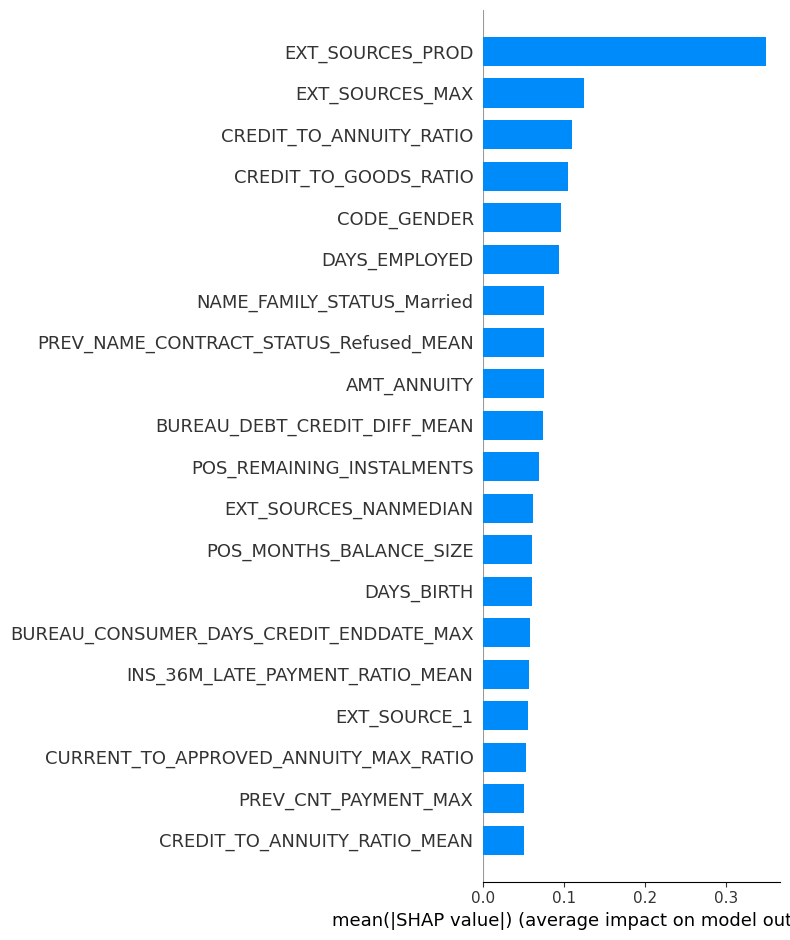

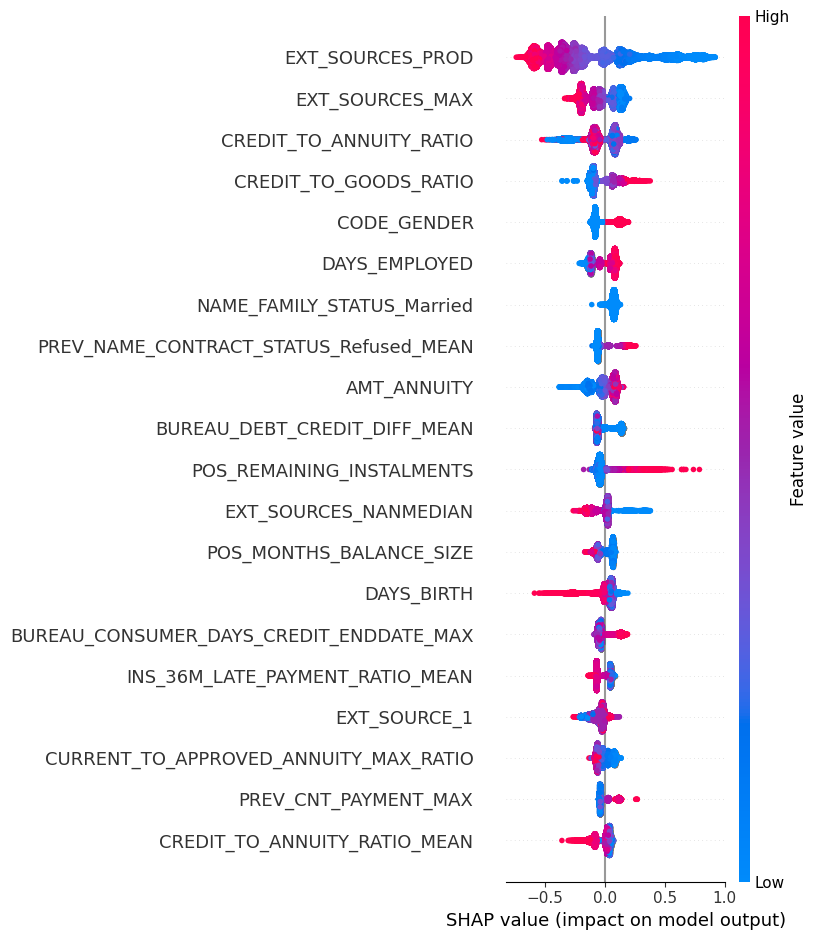

In [95]:
# Initialiser l'explainer SHAP
explainer = shap.Explainer(catboost_model_weight)

# Calculer les valeurs SHAP pour les données de test
shap_values = explainer(X_test_selected)

# Visualiser l'importance des features
shap.summary_plot(shap_values, X_test_selected, plot_type="bar")

# Visualiser les valeurs SHAP pour toutes les instances
shap.summary_plot(shap_values, X_test_selected)

## Optimisation du seuil

Calculez les probabilités de prédiction pour l'ensemble de validation ou de test.
Évaluez le coût de différentes valeurs de seuil (par exemple, de 0 à 1 avec des pas de 0.01) et sélectionnez le seuil qui minimise votre fonction de coût.

In [37]:
best_model = CatBoostClassifier(verbose=0, class_weights=class_weights_catboost, thread_count=-1, task_type="GPU",
                                    **best_params["CatBoost with weight"])

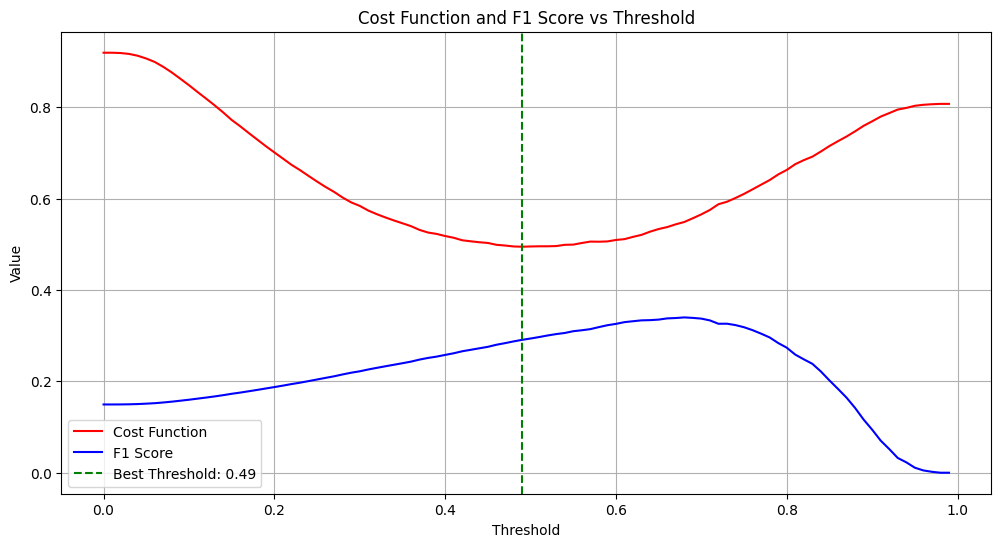

Optimal threshold: 0.49, with cost: 0.49464441779638624


In [38]:
# Entraînez le modèle avec les meilleurs hyperparamètres
best_model.fit(X_train_part, y_train_part)

# Proba de prédiction
y_proba = best_model.predict_proba(X_val_part)[:, 1]

def find_best_threshold(y_true, y_proba, cost_function):
    thresholds = np.arange(0.0, 1.0, 0.01)
    best_threshold = 0.5
    best_cost = float('inf')
    costs = []
    f1_scores = []
    for threshold in thresholds:
        y_pred = (y_proba >= threshold).astype(int)
        cost = cost_function(y_true, y_pred)
        f1 = f1_score(y_true, y_pred)
        costs.append(cost)
        f1_scores.append(f1)
        if cost < best_cost:
            best_cost = cost
            best_threshold = threshold

    # Tracer les valeurs
    plt.figure(figsize=(12, 6))
    plt.plot(thresholds, costs, label='Cost Function', color='red')
    plt.plot(thresholds, f1_scores, label='F1 Score', color='blue')
    plt.axvline(x=best_threshold, color='green', linestyle='--', label=f'Best Threshold: {best_threshold}')
    plt.xlabel('Threshold')
    plt.ylabel('Value')
    plt.title('Cost Function and F1 Score vs Threshold')
    plt.legend()
    plt.grid(True)
    plt.show()

    return best_threshold, best_cost, thresholds, costs, f1_scores


# Trouver le seuil optimal
best_threshold, best_cost, thresholds, costs, f1_scores = find_best_threshold(y_val_part, y_proba, normalized_cost_function)
print(f"Optimal threshold: {best_threshold}, with cost: {best_cost}")

In [39]:
# Prédire les probabilités sur le jeu de test
y_test_proba = best_model.predict_proba(X_test_selected)[:, 1]

# Utiliser le seuil optimisé pour les prédictions finales
y_test_pred = (y_test_proba >= best_threshold).astype(int)

# Calculer le custom_score final
final_custom_score = -normalized_cost_function(y_test, y_test_pred)
print(f"Custom Score final: {final_custom_score}")

Custom Score final: -0.4972928149846349


# Détection du Data Drift

In [103]:
# Créer un dashboard pour la détection de la dérive des données
data_drift_report = Report(metrics=[DataDriftPreset()])
data_drift_report.run(current_data=application_test, reference_data=application_train.drop(columns=['TARGET']), column_mapping=None)

# Sauvegarder le dashboard en HTML
data_drift_report.save_html("data_drift_report_test.html")

# Pipeline de prédiction

In [40]:
catboost_model = CatBoostClassifier(verbose=0, class_weights=class_weights_catboost, thread_count=-1, task_type="GPU",
                                    **best_params["CatBoost with weight"])

In [41]:
# Classe pour classifier avec un seuil personnalisé
class ThresholdClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, base_classifier, threshold=0.5):
        self.base_classifier = base_classifier
        self.threshold = threshold

    def fit(self, df, y=None):
        X = df.drop(columns=['TARGET'])
        y = df['TARGET']
        print(f"X : {X.shape}")
        print(f"y : {y.shape}")
        self.base_classifier.fit(X, y)
        return self

    def predict(self, X):
        proba = self.base_classifier.predict_proba(X)[:, 1]
        return (proba >= self.threshold).astype(int)

    def predict_proba(self, X):
        return self.base_classifier.predict_proba(X)

In [42]:
class FeatureEngineeringPipelineWrapper(BaseEstimator, TransformerMixin):
    def __init__(self, feature_engineering_pipeline, selected_features):
        self.feature_engineering_pipeline = feature_engineering_pipeline
        self.selected_features = selected_features

    def fit(self, df, y=None):
        df_transformed = self.feature_engineering_pipeline.fit(df)
        #print(f"df_tranformed: {df_transformed.shape}")
        df_transformed = clean_column_names(df_transformed)
        self.feature_engineering_pipeline.save("data/Cleaned/param")
        return df_transformed[['TARGET'] + self.selected_features]

    def transform(self, X):
        #print("transform...")
        self.feature_engineering_pipeline.load("data/Cleaned/param")
        X_transformed = self.feature_engineering_pipeline.transform(X)
        X_transformed = clean_column_names(X_transformed)
        return X_transformed[self.selected_features]

In [55]:
class PipelineWithDriftDetection:
    def __init__(self, pipeline, reference_data):
        self.pipeline = pipeline
        self.reference_data = reference_data

    def fit(self, df):
        #print("fit 1...")
        self.pipeline.fit(df)
        return self

    def predict(self, X):
        #print("predict 1...")
        self.check_data_drift(X)
        return self.pipeline.predict(X)

    def predict_proba(self, X):
        #print("predict proba...")
        self.check_data_drift(X)
        return self.pipeline.predict_proba(X)

    def check_data_drift(self, current_data):
        if 'TARGET' not in current_data.columns:
            ref_data = self.reference_data.drop(columns=['TARGET'])
        report = Report(metrics=[DataDriftPreset()])
        report.run(reference_data=ref_data, current_data=current_data)
        report.save_html("data_drift_report.html")

In [56]:
# Fonction de préparation des données
def prepare_data(df):
    # Gestion des valeurs infinies
    df = replace_infinite_values(df)

    # Initialisation du pipeline de feature engineering
    feature_engineering_pipeline = FeatureEngineeringPipeline()
    selected_features = pd.read_csv('data/Featured/features.csv')['Selected Features'].tolist()
    feature_engineering_pipeline_wrapper = FeatureEngineeringPipelineWrapper(feature_engineering_pipeline, selected_features)

    if 'TARGET' in df.columns:
        print("fit...")
        df_transformed = feature_engineering_pipeline_wrapper.fit(df)
    else:
        df['TARGET'] = np.nan
        print("predict...")
        df_transformed = feature_engineering_pipeline_wrapper.transform(df)
    
    return df_transformed

In [57]:
# Création du pipeline
pipeline = Pipeline([
    ('preprocessor', FunctionTransformer(prepare_data, validate=False)),
    ('classifier', ThresholdClassifier(catboost_model, threshold=best_threshold))
])

# Enveloppe le pipeline avec la détection de dérive
pipeline_with_drift = PipelineWithDriftDetection(pipeline, application_train)

In [58]:
# Entraîner le pipeline
pipeline_with_drift.fit(application_train)

fit...
feature_engineering - done
Bureau and bureau_balance data - done in 36s
previous_application - done in 39s
previous applications balances - done in 494s
Gestion des valeurs infinies
Colonnes supprimées (constantes): 0, Colonnes restantes: 733
Initial df memory usage is 1728.21 MB for 851 columns
Final memory usage is: 631.69 MB - decreased by 63.4%
X : (307511, 349)
y : (307511,)


In [59]:
# Sauvegarder le pipeline
joblib.dump(pipeline_with_drift, 'pipeline_credit_scoring_with_drift_detection.joblib')

['pipeline_credit_scoring_with_drift_detection.joblib']

<b>Test du pipeline

In [60]:
# Division des données en ensembles d'entraînement et de test
train, test = train_test_split(application_train, test_size=0.2, random_state=42, stratify=application_train['TARGET'])
df_test = test.drop(columns=['TARGET'])

# Prédictions sur df_test
predictions = pipeline_with_drift.predict(df_test)
#predictions_proba = pipeline_with_drift.predict_proba(df_test)[:, 1]

predict...
Bureau and bureau_balance data - done in 36s
previous_application - done in 39s
Gestion des valeurs infinies
Initial df memory usage is 398.61 MB for 851 columns
Final memory usage is: 119.07 MB - decreased by 70.1%
previous applications balances - done in 496s


In [61]:
predictions.shape

(61503,)

In [62]:
test.shape

(61503, 122)

In [63]:
# Créer un DataFrame des prédictions avec les user_id
df_predictions = pd.DataFrame({
    'user_id': df_test["SK_ID_CURR"],
    'prediction': predictions,
    #'prediction_proba': predictions_proba
})

In [64]:
# Calculer le ROC AUC score
#roc_auc = roc_auc_score(y_df_test, predictions_proba)

# Calculer l'accuracy
accuracy = accuracy_score(test['TARGET'], predictions)

#print("ROC AUC Score:", roc_auc)
print("Accuracy:", accuracy)

Accuracy: 0.7041932913841601
